In [3]:
import matplotlib.pyplot as plt
import numpy as np

Equation of motion for a single electron passing a region with electromagnetic waves.

Lorentz Force: $$\vec{F}_L=e\left[\vec{E}+\vec{\beta}\times\vec{B}\right]$$

By using the relativistic newton's second law, we obtain the equation of motion: $$M\dot{\vec{\beta}} = \frac{1}{\gamma m}\vec{F}_{L}$$, where $\gamma = \left(1-\beta^2\right)^{-1/2}$ and $M = 1 + \frac{\gamma^2}{\beta}\vec{\beta}\vec{\beta}^T$.

To use a finite difference method, we use

$$\dot{\vec{\beta}} = \frac{1}{\gamma m}M^{-1}\vec{F}_L$$

where

$$M^{-1} = 1 - \frac{\gamma^2}{\beta (1+\gamma^2 \beta)}\vec{\beta}\vec{\beta}^T$$

Writing the lorentz factor $\gamma$ in terms of $\beta$

$$M^{-1} = 1 - \frac{1}{\beta (1+\beta-\beta^2)}\vec{\beta}\vec{\beta}^T$$

therefore

$$\dot{\vec{\beta}} = \frac{\sqrt{1-\beta^2}}{m}\left(1 - \frac{1}{\beta (1+\beta-\beta^2)}\vec{\beta}\vec{\beta}^T\right)\vec{F}_L$$

In [4]:
c_vel = 299792458 # m/s
h = 6.62607015e-34 # J s
e = 1.602176634e-19 # C
eV_to_s = 6.58*1e-25*1000 # s*MeV
eV_to_G = 1.95*1e-20*(1000**2) # MeV2/Gauss
eV_to_m = 1.98*1e-14*1000/100 # MeV*m

Description in terms of momenta

$$\vec{F}_L = e\left[\vec{E} + \frac{1}{\sqrt{m^2 + p^2}} \vec{p}\times\vec{B}\right]$$

In [56]:
initKinEnergy = 0.05 # MeV
initPos = np.array([0,0,0])
mass = 0.511 # MeV
initTotEnergy = initKinEnergy + mass # MeV
initMomentum = np.sqrt(initTotEnergy**2 - mass**2)*np.array([0,0,1])
charge = 0.303
# The steps must follow the Nyquist-Shannon theorem in accordance with the E&M fields
stepsT = 100000
finalT = 1e11 # MeV-1
deltaT = finalT/stepsT # MeV-1
Titer = np.arange(0,finalT,deltaT) # MeV-1

For now, we assume the Lorentz Force coming from electromagnetic plane waves, so

$$\vec{E} = E_{0} \hat{z} \cos{\omega t} , \quad \text{and} \quad \vec{B} = B_{0}\hat{y} \cos{\omega t} $$

In [59]:
# E&M fields
# TODO: These fields must follow laser characteristics
E0 = 5*1e9 # V/m
B0 = (E0/c_vel)*1e4 # (V s/m2 = T)*1e4 = G
wl = 10*1e-6 # m
phase = 30*np.pi/180
print(f'Wavelength: {wl} m')
print(f'Frequency: {c_vel/wl} Hz')
print(f'Period: {wl/c_vel} s')
wl_eV = wl/eV_to_m # MeV-1
B0_eV = B0*eV_to_G # MeV**2
E0_eV = B0_eV
E = lambda t, z: np.array([0,0,E0_eV*np.cos(2*np.pi*t/wl_eV - wl_eV*z - phase)]) # MeV**2
B = lambda t, z: np.array([0,B0_eV*np.cos(2*np.pi*t/wl_eV - wl_eV*z - phase),0]) # MeV**2

Wavelength: 9.999999999999999e-06 m
Frequency: 29979245800000.004 Hz
Period: 3.3356409519815204e-14 s


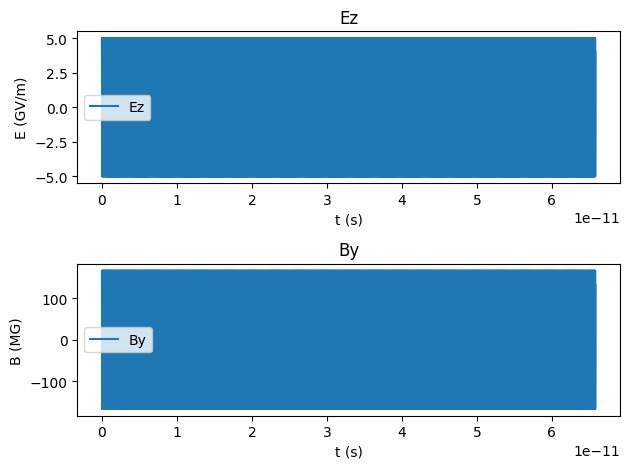

In [ ]:
# E and B plots
# TODO: These plots must be animated in time, and show the fields in 3D ideally, or 2D
fig, ax = plt.subplots(2, 1)
ax[0].plot(Titer*eV_to_s, [E(t,0)[2]*c_vel*1e-9/(eV_to_G*1e4) for t in Titer], label='Ez')
ax[0].set_title('Ez')
ax[0].set_xlabel(r't (s)')
ax[0].set_ylabel(r'E (GV/m)')
ax[0].set_ylim(-1.1*E0*1e-9,1.1*E0*1e-9)
ax[0].legend()
ax[1].plot(Titer*eV_to_s, [B(t,0)[1]*1e-3/eV_to_G for t in Titer], label='By')
ax[1].set_title('By')
ax[1].set_xlabel(r't (s)')
ax[1].set_ylabel(r'B (MG)')
ax[1].set_ylim(-1.1*B0*1e-3,1.1*B0*1e-3)
ax[1].legend()
fig.tight_layout()
plt.show()

In [61]:
# Finite difference method
# WARNING: The evaluation of the E&M fields must be changed in accordance with the definition of the lambda functions
momentos = np.zeros((len(Titer),3))
pos = np.zeros((len(Titer),3))
LorentzVecs = np.zeros((len(Titer),3))
momentos[0] = initMomentum
pos[0] = initPos
for i in range(1,len(Titer)):
    momenta = momentos[i-1].copy()
    LorentzB = np.cross(momenta,B(Titer[i-1], pos[i-1][2]))
    Einv = 1/np.sqrt(mass**2 + np.dot(momenta,momenta))
    Lorentz = (E(Titer[i-1],pos[i-1][2]) + Einv*LorentzB)*charge
    LorentzVecs[i-1] = Lorentz
    momenta += Lorentz*deltaT
    pos[i] = pos[i-1] + momenta*deltaT*mass/(mass*2 + np.dot(momenta,momenta))
    momentos[i] = momenta

In [62]:
def energyKin(momenta):
    return np.sqrt(mass**2 + np.dot(momenta,momenta)) - mass

In [63]:
def gamma(momenta):
    E = np.sqrt(mass**2 + np.dot(momenta,momenta))
    return E/mass

In [64]:
def betaMom(momenta):
    E = np.sqrt(mass**2 + np.dot(momenta,momenta))
    gamm = gamma(momenta)
    return (gamm*E - mass)/(gamm*np.linalg.norm(momenta))

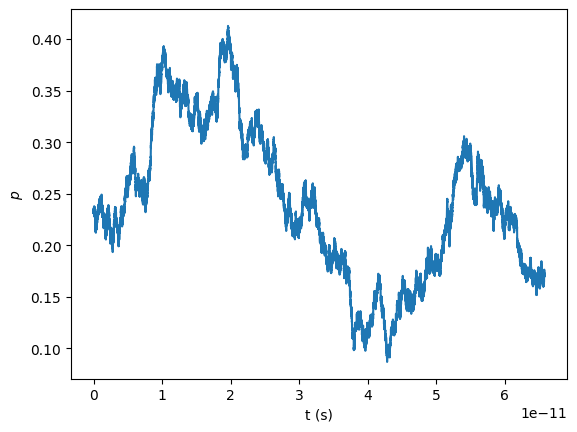

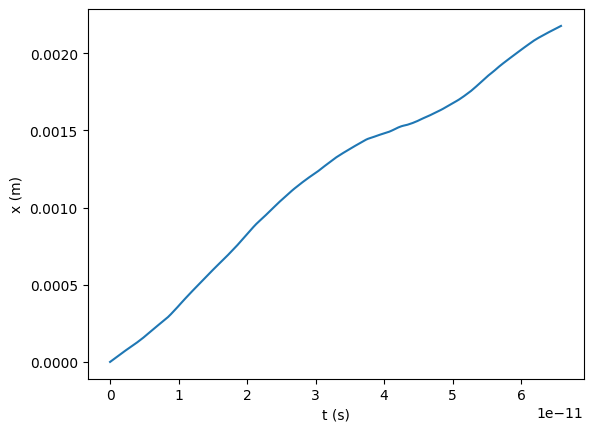

In [75]:
# Momenta plot
plt.plot(Titer*eV_to_s,np.sqrt(momentos[:,0]**2 + momentos[:,1]**2 + momentos[:,2]**2),label='v')
#plt.ylim(0,1)
plt.xlabel('t (s)')
plt.ylabel(r'$p$')
plt.show()

# Displacement plot
plt.plot(Titer*eV_to_s,np.sqrt(pos[:,0]**2+pos[:,1]**2 + pos[:,2]**2)*eV_to_m,label='v')
plt.xlabel('t (s)')
plt.ylabel('x (m)')
plt.show()

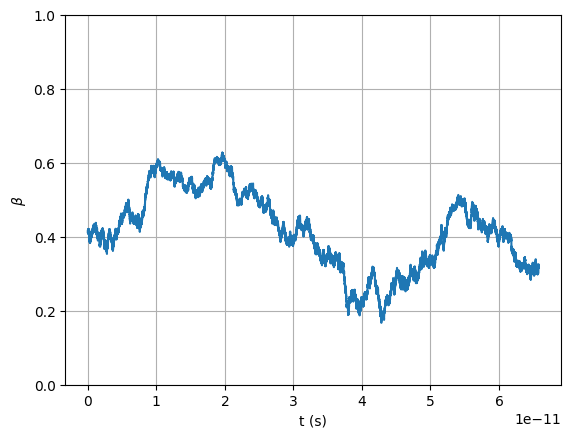

In [76]:
# Beta plot
plt.plot(Titer*eV_to_s,[betaMom(momentos[j]) for j in range(len(momentos))],label='v')
plt.ylim(0,1)
plt.xlabel('t (s)')
plt.ylabel(r'$\beta$')
plt.grid()
plt.show()

In [77]:
momentosMag = np.sqrt(momentos[:,0]**2 + momentos[:,1]**2 + momentos[:,2]**2)
betas = np.array([betaMom(momentos[j]) for j in range(len(momentos))])

Path plots

/tmp/ipykernel_128293/3916668111.py:2: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cm = plt.cm.get_cmap('viridis')


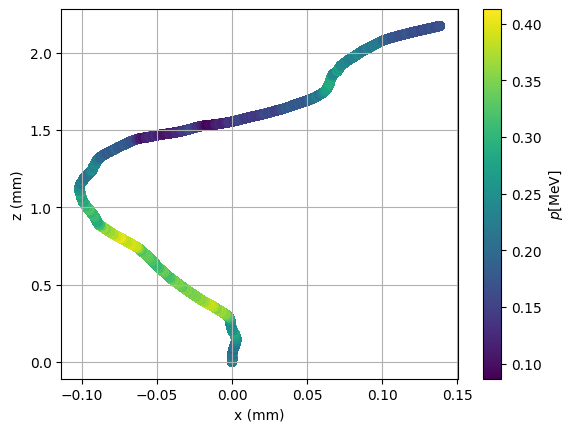

/tmp/ipykernel_128293/3916668111.py:11: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cm = plt.cm.get_cmap('viridis')


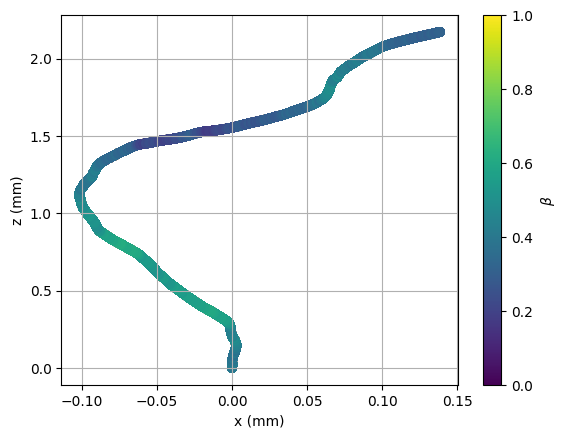

In [78]:
# 2d position plot
cm = plt.cm.get_cmap('viridis')
sc = plt.scatter(pos[:,0]*eV_to_m*1e3,pos[:,2]*eV_to_m*1e3,c=momentosMag,cmap=cm,vmin=min(momentosMag),vmax=max(momentosMag))
plt.colorbar(sc,label=r'$p$[MeV]')
plt.xlabel('x (mm)')
plt.ylabel('z (mm)')
plt.grid()
plt.show()

# 2d position plot
cm = plt.cm.get_cmap('viridis')
sc = plt.scatter(pos[:,0]*eV_to_m*1e3,pos[:,2]*eV_to_m*1e3,c=betas,cmap=cm,vmin=0,vmax=1)
plt.colorbar(sc,label=r'$\beta$')
plt.xlabel('x (mm)')
plt.ylabel('z (mm)')
plt.grid()
plt.show()

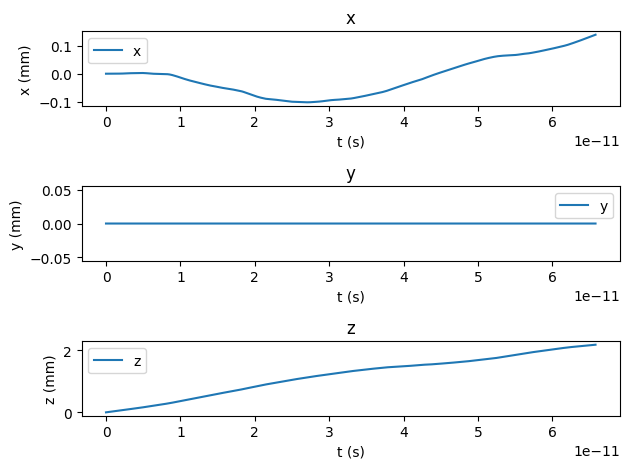

In [79]:
# Displacement plots
fig, ax = plt.subplots(3, 1)
ax[0].plot(Titer*eV_to_s, pos[:,0]*eV_to_m*1e3, label='x')
ax[0].set_title('x')
ax[0].set_xlabel(r't (s)')
ax[0].set_ylabel(r'x (mm)')
ax[0].legend()
ax[1].plot(Titer*eV_to_s, pos[:,1]*eV_to_m*1e3, label='y')
ax[1].set_title('y')
ax[1].set_xlabel(r't (s)')
ax[1].set_ylabel(r'y (mm)')
ax[1].legend()
ax[2].plot(Titer*eV_to_s, pos[:,2]*eV_to_m*1e3, label='z')
ax[2].set_title('z')
ax[2].set_xlabel(r't (s)')
ax[2].set_ylabel(r'z (mm)')
ax[2].legend()
fig.tight_layout()
plt.show()

In [80]:
print(f'{round(energyKin(momentos[-1]) - initKinEnergy,3)} MeV ganados')
print(f'{round(np.linalg.norm(pos[-1])*eV_to_m*1e3,3)} um recorridos')

-0.023 MeV ganados
2.176 um recorridos
